<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](https://github.com/ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [10.0 Gaussian Process Emulators and Surrogate Models](https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.00-Gaussian-Process-Emulators-and-Surrogate-Models.html) | [Contents](toc.html) | [10.2 A simple example of Bayesian quadrature](https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.02-Bayesian-quadrature.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/10.01-Contributed-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.01-Contributed-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 10.1 Using GPflow package for Gaussian Process Regression


Created by Bridgette Befort (bbefort@nd.edu)

The following example was adapted from:

De G. Matthews, A. G., Van Der Wilk, M., Nickson, T., Fujii, K., Boukouvalas, A., León-Villagrá, P., ... & Hensman, J. (2017). GPflow: A Gaussian process library using TensorFlow. The Journal of Machine Learning Research, 18(1), 1299-1304.

McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 10: Gaussian Process Emulators and Surrogate Models, Springer, https://link.springer.com/chapter/10.1007/978-3-319-99525-0_10

## 10.1.1 Objectives and Organization

1. GPflow example for the function $y = sin(x) + cos(x)$
  * Setup steps
  * Kernels
  * Varying amount of train/test data
    
    
2. Apply GPflow tool to shock breakout time dataset
  * Without scaling
  * With scaling
  

## 10.1.2 Import Libraries

Note: GPflow needs to be installed

https://gpflow.readthedocs.io/en/master/intro.html

ACTION ITEM: Streamline this installation on Colab. Which version of GPFlow should be installed?

In [1]:
import numpy as np
import pandas as pd
import unyt as u
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

## 10.1.3 Define Functions

In [2]:
def shuffle_and_split(df, n_params, fraction_train=0.8):
    """Randomly shuffles the DataFrame and extracts the train and test sets
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe with the
    n_params : int
        Number of parameters in the model
    fraction_train : float
        Fraction to use as training data. The remainder will be used for testing. Default is 0.8
    Returns
    -------
    x_train : np.ndarray
        Training inputs
    y_train : np.ndarray
        Training results
    x_test : np.ndarray
        Testing inputs
    y_test : np.ndarray
        Testing results
    """

    # Return values for all samples (liquid and vapor)
    data = df.values
    fraction_test = 1.0 - fraction_train
    total_entries = data.shape[0]
    train_entries = int(total_entries * fraction_train)
    # Shuffle the data before splitting train/test sets
    np.random.shuffle(data)

    # x = params, y = output
    x_train = data[:train_entries, : n_params].astype(np.float64)
    y_train = data[:train_entries, -1].astype(np.float64)
    x_test = data[train_entries:, : n_params].astype(np.float64)
    y_test = data[train_entries:, -1].astype(np.float64)

    return x_train, y_train, x_test, y_test

In [3]:
def run_gpflow_scipy(x_train, y_train, kernel):
    """Fits GP model to the training data
    Parameters
    ----------
    x_train : np.ndarray
        Training inputs
    y_train : np.ndarray
        Training results
    kernel : function
        GP flow kernel function
    Returns
    -------
    model : 
        fitted GP flow model
    """
    # Create the model
    model = gpflow.models.GPR(
        data=(x_train, y_train.reshape(-1, 1)),
        kernel=kernel,
        mean_function=gpflow.mean_functions.Linear(
            A=np.zeros(x_train.shape[1]).reshape(-1, 1)
        ),
    )

    # Print initial values
    print_summary(model, fmt="notebook")

    # Optimize model with scipy
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(model.training_loss, model.trainable_variables)

    # Print the optimized values
    print_summary(model, fmt="notebook")

    # Return the model
    return model

In [4]:
def plot_models(models, x_data, y_data, xylim_low=0, xylim_high=1):
    """Plot the performance of one or more GP models for some data x_data
    Parameters
    ----------
    models : dict { label : model }
        Each model to be plotted (value, GPFlow model) is provided
        with a label (key, string)
    x_data : np.array
        data to create model predictions for
    y_data : np.ndarray
        correct answer
    xylim_low : float, opt
        lower x and y limits of the plot, default 0
    xylim_high : float, opt
        upper x and y limits of the plot, default 1
    Returns
    -------
    """

    plt.plot(
        np.arange(xylim_low, xylim_high + 100, 100),
        np.arange(xylim_low, xylim_high + 100, 100),
        color="xkcd:blue grey",
        label="y=x",
    )

    for (label, model) in models.items():
        gp_mu, gp_var = model.predict_f(x_data)
        y_data_physical = y_data
        gp_mu_physical = gp_mu
        plt.scatter(y_data_physical, gp_mu_physical, label=label)
        sumsqerr = np.sum((gp_mu_physical - y_data_physical.reshape(-1, 1)) ** 2)
        print("Model: {}. Sum squared err: {:f}".format(label, sumsqerr))

    plt.xlim(xylim_low, xylim_high)
    plt.ylim(xylim_low, xylim_high)
    plt.xlabel("Actual")
    plt.ylabel("Model Prediction")
    plt.legend()
    ax = plt.gca()
    ax.set_aspect("equal", "box")

## 10.1.4 GPFlow Example

**Objective**: Use GP flow to predict output of $y = sin(x) + cos(x)$

### 10.1.4.1 Setup

#### 10.1.4.1.1 Step 1: Generate dataset

Text(0, 0.5, 'y')

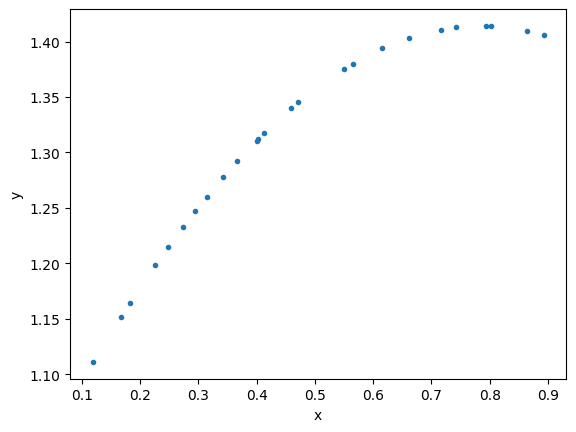

In [5]:
#Specify number of samples
n = 25

#Generate samples of x
x = np.random.rand(n,1)

#Calculate y
y = np.sin(x) + np.cos(x)

#Visualize
plt.plot(x,y,'.')
plt.xlabel('x')
plt.ylabel('y')

#### 10.1.4.1.2 Step 2: Split into train/test sets

In [6]:
#To use shuffle_and_split function, the data needs to be in a pandas dataframe
data = np.concatenate((x,y),axis=1)
data = pd.DataFrame(data,columns=['x','y'])

In [44]:
type(data)

pandas.core.frame.DataFrame

In [7]:
#Specify number of params
n_params = 1

#Apply shuffle_and_split function
x_train, y_train, x_test, y_test = shuffle_and_split(data, n_params, fraction_train=0.8)

#### 10.1.4.1.3 Step 3: Fit GP model

In [8]:
# Fit model--using RBF kernel
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model = {'RBF': model_RBF}

2024-03-27 20:51:43.644328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 20:51:43.649270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 20:51:43.649403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 20:51:43.649843: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


2024-03-27 20:51:44.113294: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-03-27 20:51:45.581071: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7be6ff0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.24691024]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.50019977]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.33549712111635466
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.18772]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000227340567265e-06


#### 10.1.4.1.4 Step 4: Compare Models

##### 10.1.4.1.4.1 Train

Model: RBF. Sum squared err: 0.000001


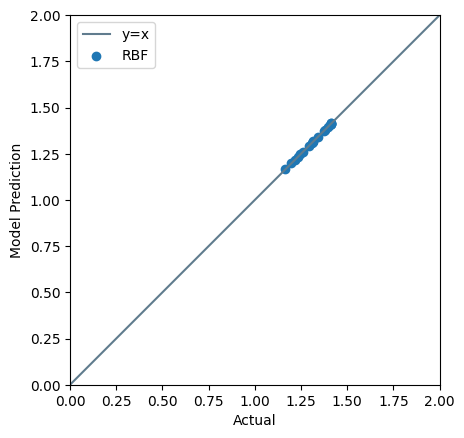

In [9]:
plot_models(model, x_train, y_train, 0, 2)

##### 10.1.4.1.4.2 Test

Model: RBF. Sum squared err: 0.000002


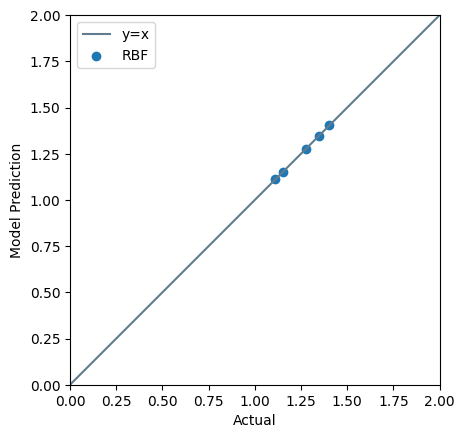

In [10]:
plot_models(model, x_test, y_test, 0, 2)

#### 10.1.4.1.5 Step 5: Analyze model predictions 

In [11]:
def plot_function(models,train,test):
    
    """Plot the performance (mean and variance) of one or more GP models along with the original train and test data
    Parameters
    ----------
    models : dict { label : model }
        Each model to be plotted (value, GPFlow model) is provided
        with a label (key, string)
    train : np.array
        array of training data, both and x and y values
    test : np.ndarray
        array of test data, both and x and y values
    Returns
    -------
    """
    #x data samples
    xx = np.linspace(0, 1.0, 100)[:,None]
    
    for (label, model) in models.items():
        
        #use model to predict output (y) given x data
        mean, var = model.predict_f(xx)
        #plot mean as line
        plt.plot(xx, mean, lw=2, label="GP model" + label)
        #plot variance as a shaded area
        plt.fill_between(
            xx[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            alpha=0.25,
        )

    #Plot training and testing points
    if train.shape[0] > 0:
        x_train = train[:, 0]
        y_train = train[:, 1]
        plt.plot(x_train, y_train, "s", color="black", label="Train")
    if test.shape[0] > 0:
        x_test = test[:, 0]
        y_test = test[:, 1]
        plt.plot(x_test, y_test, "ro", label="Test")
        
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

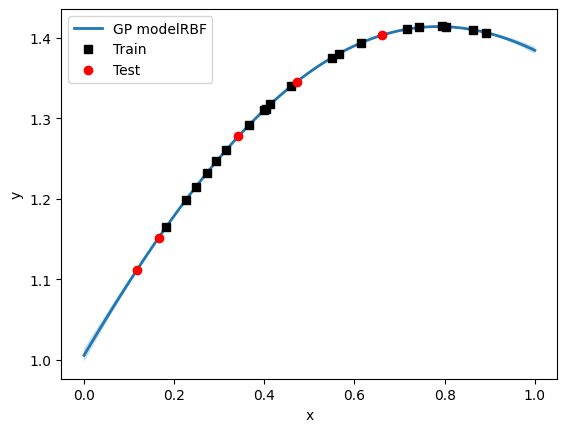

In [12]:
#Make sure the y training and testing data has the correct shape
y_train.shape = (20,1)
y_test.shape = (5,1)
#Make arrays
train = np.concatenate((x_train,y_train),axis=1)
test = np.concatenate((x_test,y_test),axis=1)
 
plot_function(model,train,test)

### 10.1.4.2 What happens if we use different kernels?

GP flow has many different available kernel functions: https://gpflow.readthedocs.io/en/master/gpflow/kernels/

Here we will examine a few options:

1. Constant

$k(x,y) = \sigma^2$

where $\sigma^2$ is the variance parameter

2. Linear

$k(x,y) = (\sigma^2xy+\gamma)^d$

where $\sigma^2$ is the variance parameter, $\gamma$ is the offset parameter, and $d$ is the degree parameter

3. Radial Basis Function

$k(r) = \sigma^2 exp[-\frac{r^2}{2}]$

where $r$ is the Euclidean distance and $\sigma^2$ is the variance parameter

4. Cosine

$k(r) = \sigma^2cos(2\pi d)$

where $r$ is the Euclidean distance, $\sigma^2$ is the variance parameter, and $d$ is the sum of the per-dimension differences between the input points scaled by the lenghtscale parameter $l$ 

5. Matern12

$k(r) = \sigma^2exp[-r]$

where $r$ is the Euclidean distance and $\sigma^2$ is the variance parameter

6. Matern32

$k(r) = \sigma^2(1+\sqrt{3}r)exp[-\sqrt{3}r]$

where $r$ is the Euclidean distance and $\sigma^2$ is the variance parameter

6. Matern52

$k(r) = \sigma^2(1+\sqrt{5}r+\frac{5}{3}r^2)exp[-\sqrt{5}r]$

where $r$ is the Euclidean distance and $\sigma^2$ is the variance parameter

In [13]:
#Fit models using different kernels
model_constant = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Constant())
model_linear = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Linear())
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF())
model_cosine = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Cosine())
model_M12 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern12())
model_M32 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern32())
model_M52 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern52())

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.33824296]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.15413]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.071238800463179e-10
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00073495050675319


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.33823555]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.15413]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.133409187528426e-10
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0007349873493345606


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.24691024]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.50019977]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.33549712111635466
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.18772
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000227340567265e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.25649338]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.87089687]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0667643901578221
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.18454
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.34003314]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.11998]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0011884114216531073
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.8056789414652086
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000008399471998e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.33262666]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.93193458]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.041370427396367516
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.71744
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.000000127881477e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.31298375]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.51292509]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.3789963231388854
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.04212
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.00000000020865e-06


#### 10.1.4.2.1 Constant

In [14]:
model = {'Constant':model_constant}

Train

Model: Constant. Sum squared err: 0.014700


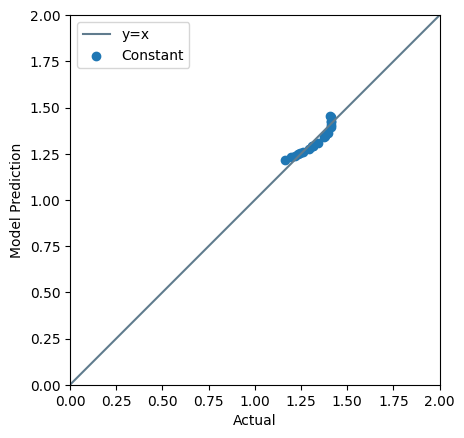

In [15]:
plot_models(model, x_train, y_train,0,2)

Test

Model: Constant. Sum squared err: 0.012036


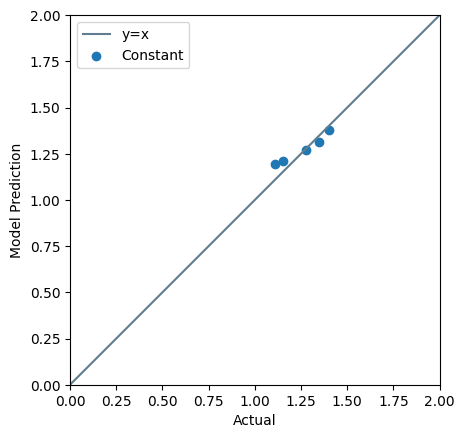

In [16]:
plot_models(model, x_test, y_test,0,2)

#### 10.1.4.2.2 Linear

In [17]:
model = {'Linear':model_linear}

Train

Model: Linear. Sum squared err: 0.014700


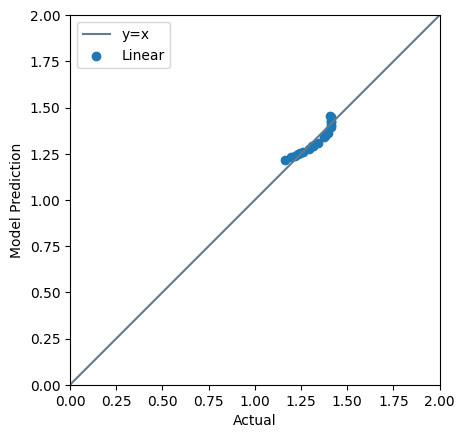

In [18]:
plot_models(model, x_train, y_train,0,2)

Test

Model: Linear. Sum squared err: 0.012036


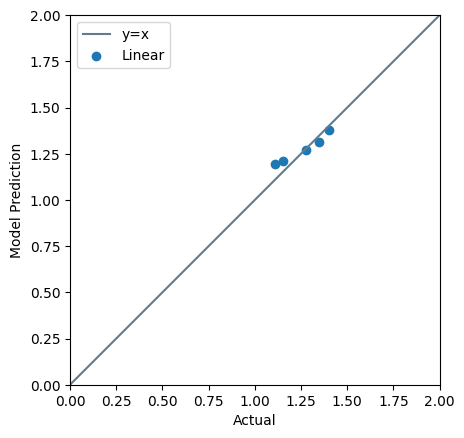

In [19]:
plot_models(model, x_test, y_test,0,2)

#### 10.1.4.2.3 RBF

In [20]:
model = {'RBF':model_RBF}

Train

Model: RBF. Sum squared err: 0.000001


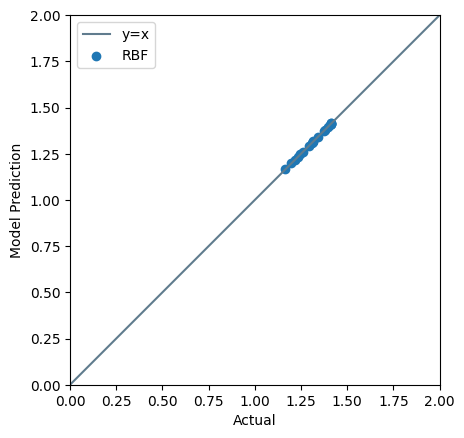

In [21]:
plot_models(model, x_train, y_train,0,2)

Test

Model: RBF. Sum squared err: 0.000002


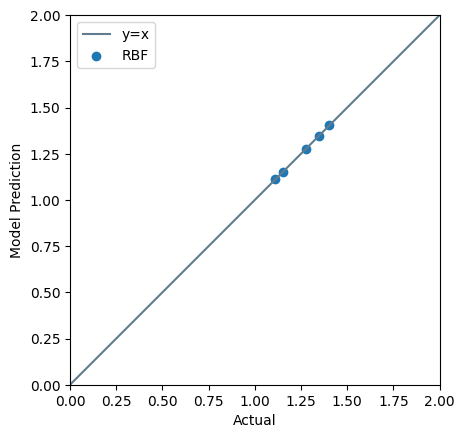

In [22]:
plot_models(model, x_test, y_test,0,2)

#### 10.1.4.2.4 Cosine

In [23]:
model = {'Cosine':model_cosine}

Train

Model: Cosine. Sum squared err: 0.000001


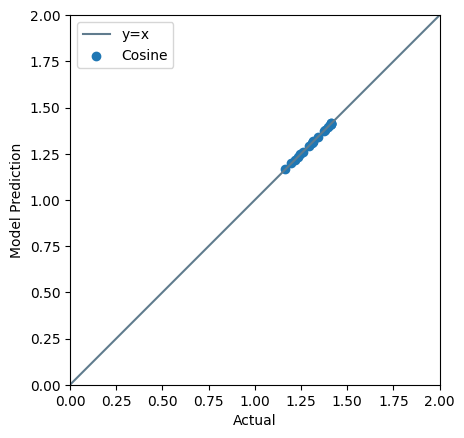

In [24]:
plot_models(model, x_train, y_train,0,2)

Test

Model: Cosine. Sum squared err: 0.000004


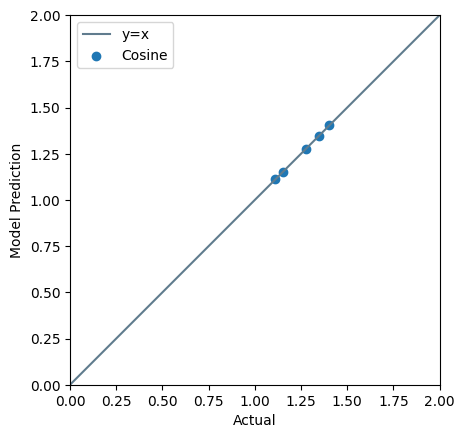

In [25]:
plot_models(model, x_test, y_test,0,2)

#### 10.1.4.2.5 Matern

In [26]:
model = {'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

Train

Model: Matern12. Sum squared err: 0.000000
Model: Matern32. Sum squared err: 0.000000
Model: Matern52. Sum squared err: 0.000000


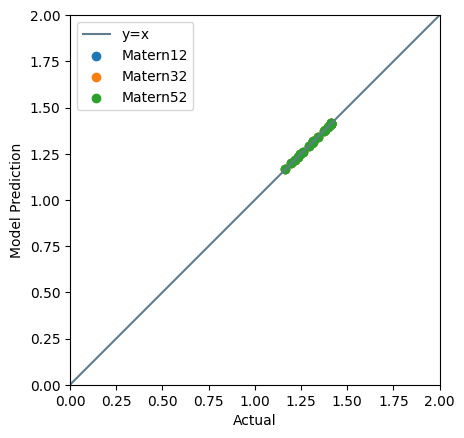

In [27]:
plot_models(model, x_train, y_train,0,2)

Test

Model: Matern12. Sum squared err: 0.001172
Model: Matern32. Sum squared err: 0.000041
Model: Matern52. Sum squared err: 0.000003


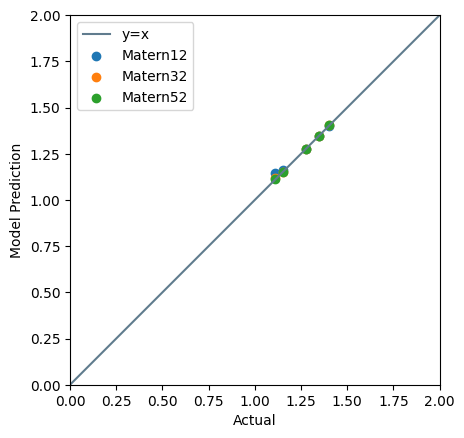

In [28]:
plot_models(model, x_test, y_test,0,2)

#### 10.1.4.2.6 Analyze Model Predictions

All Kernels

In [29]:
model = {'Constant':model_constant,'Linear':model_linear,'RBF':model_RBF,'Cosine':model_cosine,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

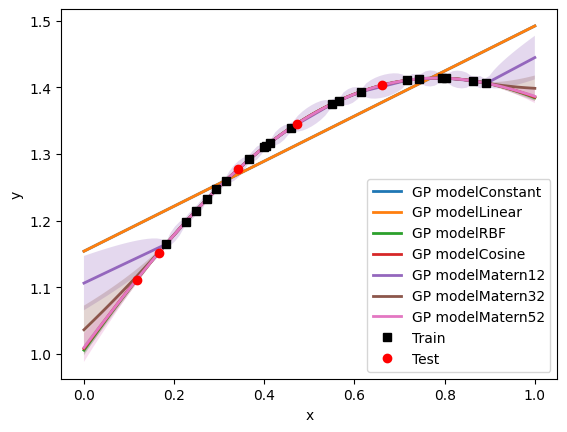

In [30]:
plot_function(model,train,test)

RBF and Matern Kernels

In [31]:
model = {'RBF':model_RBF,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

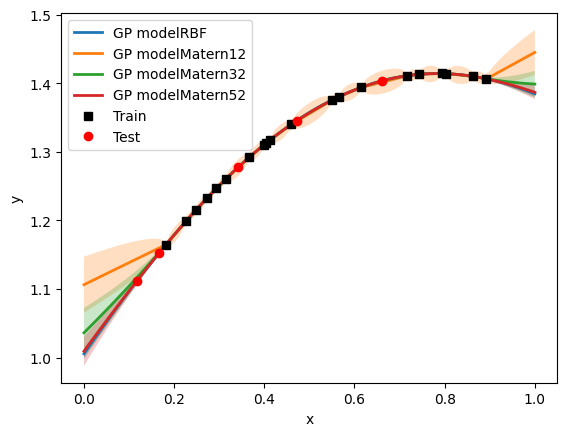

In [32]:
plot_function(model,train,test)

RBF, Matern32, and Matern52 Kernels

Note: All three of these kernels give very small variances.

In [33]:
model = {'RBF':model_RBF,'Matern32':model_M32,'Matern52':model_M52}

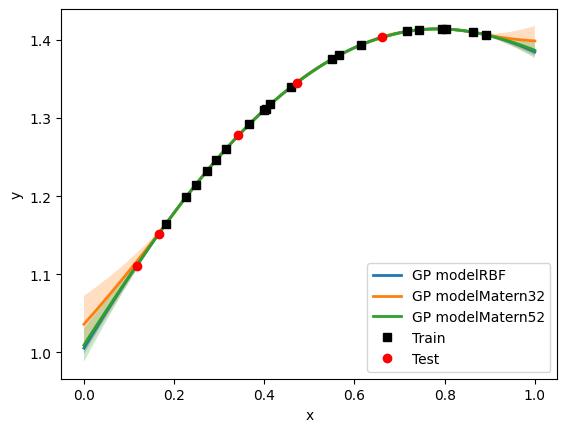

In [34]:
plot_function(model,train,test)

### 10.1.4.3 What happens if we use different train/test fractions?

The example above used an 80/20 train/test split. How much data do we need to train with using the RBF and Matern kernels?

#### 10.1.4.3.1 50/50 Split

In [35]:
x_train, y_train, x_test, y_test = shuffle_and_split(data, n_params, fraction_train=0.5)
# Fit model
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model_M12 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern12())
model_M32 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern32())
model_M52 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern52())

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.26859656]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.49957898]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.3228375475067022
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.17484]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000000621036812e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.38181351]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.09259]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0017741376503288603
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5520288591634157
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.000001991517012e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.35265805]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.94357034]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.03334034900902006
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.44971
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.000007650151267e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.33005248]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.63040332]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.24192193667944162
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.75574
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000000908888665e-06


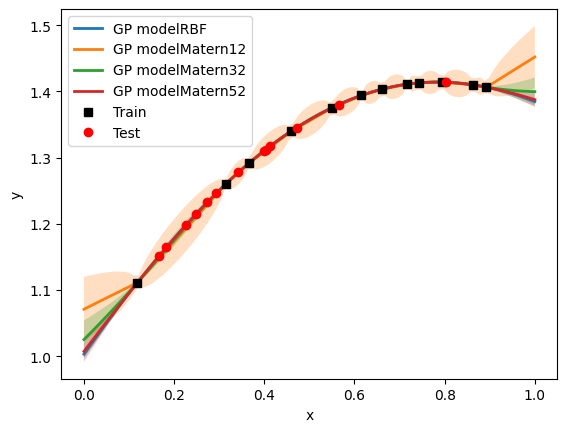

In [36]:
model = {'RBF':model_RBF,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

y_train.shape = (12,1)
y_test.shape = (13,1)
train = np.concatenate((x_train,y_train),axis=1)
test = np.concatenate((x_test,y_test),axis=1)
 
plot_function(model,train,test)

#### 10.1.4.3.2 25/75 Split

In [37]:
x_train, y_train, x_test, y_test = shuffle_and_split(data, n_params, fraction_train=0.25)
# Fit model
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model_M12 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern12())
model_M32 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern32())
model_M52 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern52())

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.41512404]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.05009]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.005794610490340693
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.39893662]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.000000022130406e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.41947851]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.11986]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0002526503383702164
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.08390090600333898
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000009710860155e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.42362798]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.10604]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0007280178198248297
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.23982528991802218
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000025723456267e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.42275737]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.08676]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0019134145446262048
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.34469183388757735
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000001503571045e-06


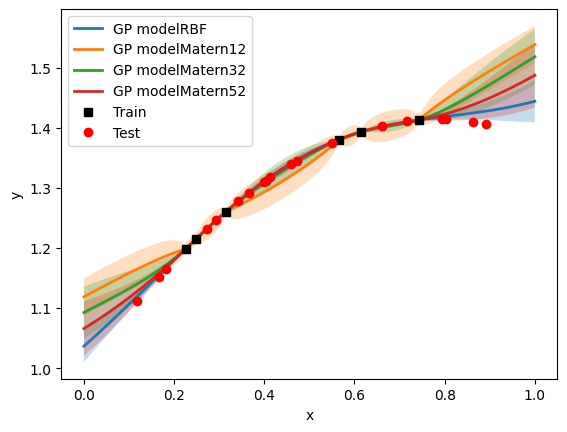

In [38]:
model = {'RBF':model_RBF,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

y_train.shape = (6,1)
y_test.shape = (19,1)
train = np.concatenate((x_train,y_train),axis=1)
test = np.concatenate((x_test,y_test),axis=1)
 
plot_function(model,train,test)

#### 10.1.4.3.3 10/90 Split

In [39]:
x_train, y_train, x_test, y_test = shuffle_and_split(data, n_params, fraction_train=0.1)
# Fit model
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model_M12 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern12())
model_M32 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern32())
model_M52 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern52())

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.27975995]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.1894]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,8.45048883290542e-14
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[7.15638]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.27976]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.1894]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.757923707472837e-13
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.44343
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.000000000038892e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.27976052]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.1894]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,9.978963822833103e-14
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,7.84945
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000000000000014e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.27976005]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[1.1894]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.4189968593258167e-12
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,7.39773
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000000000000044e-06


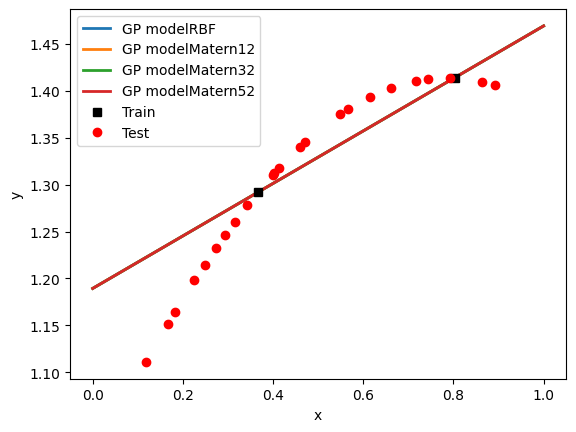

In [40]:
model = {'RBF':model_RBF,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

y_train.shape = (2,1)
y_test.shape = (23,1)
train = np.concatenate((x_train,y_train),axis=1)
test = np.concatenate((x_test,y_test),axis=1)
 
plot_function(model,train,test)

## 10.1.5 Apply GPflow code to Breakout Time Dataset

**Objective**: Use GPflow to predict breakout time given five parameters (thickness, laser energy, Be gamma, wall opacity, and flux limiter)

Kernels: RBF and Matern

### 10.1.5.1 Load in Dataset as a dataframe

In [41]:
csv_path = '/home/zpqls/workspace/csv/CRASHBreakout.csv'

In [42]:
df = pd.read_csv(csv_path)
df = df.drop(['cmeasure.1','measure.2','measure.3'],axis=1)
df.columns = ["thickness",
                "laser_energy",
                "Be_gamma",
                "wall_opacity",
                "flux_limiter",
                "breakout_time"]

FileNotFoundError: [Errno 2] No such file or directory: '/home/zpqls/workspace/CRASHBreakout.csv'

In [ ]:
pd.options.display.max_rows=104
df

,thickness,laser_energy,Be_gamma,wall_opacity,flux_limiter,breakout_time
0,18.44,3780,1.522,0.776,0.0587,390.699
1,18.32,3640,1.500,0.976,0.0500,415.353
2,19.59,3830,1.472,0.729,0.0544,440.499
3,18.76,3950,1.517,0.938,0.0563,400.380
4,21.56,3650,1.444,0.910,0.0540,495.513
5,20.41,3660,1.406,0.986,0.0560,490.159
6,21.43,3830,1.456,0.748,0.0607,475.382
7,20.98,3950,1.561,0.824,0.0520,435.335
8,18.63,3720,1.683,0.738,0.0615,345.069
9,19.78,3800,1.644,0.852,0.0611,375.399


### 10.1.5.2 Split into training and test sets and fit GP model without normalizing

I was curious how this would look

In [ ]:
n_params=5
x_train, y_train, x_test, y_test = shuffle_and_split(df, 5, fraction_train=0.8)

In [ ]:
# Fit model
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model_M12 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern12(lengthscales=np.ones(n_params)))
model_M32 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern32(lengthscales=np.ones(n_params)))
model_M52 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern52(lengthscales=np.ones(n_params)))

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[1.91443800e+01...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[54.73629]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,226.80497
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1.46126320e+02, 1.00001000e+00, 1.31619195e+03..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,179.08104


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[2.0563080e+01...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[15.85234]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,351.72821
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[51.45682, 9.34374, 7.41895..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,298.60355


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[2.4126400e+01...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[56.70795]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,888.71606
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[5.16196400e+01, 1.00321000e+00, 6.71495794e-11..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,891.51987


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[2.42766600e+01...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[20.1795]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,871.98544
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[4.52625900e+01, 1.00025000e+00, 6.66376893e-11..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,904.56343


In [ ]:
model = {'RBF':model_RBF,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

Model: RBF. Sum squared err: 8374.608113
Model: Matern12. Sum squared err: 12998.966192
Model: Matern32. Sum squared err: 12146.129555
Model: Matern52. Sum squared err: 14060.056486


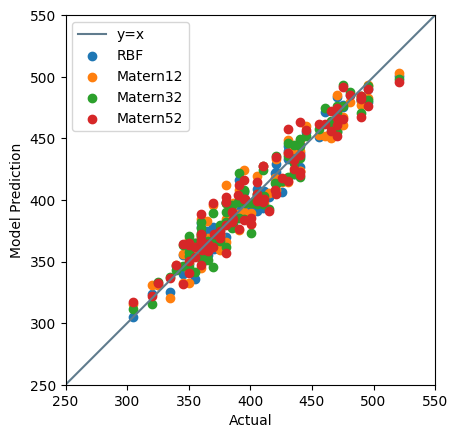

In [ ]:
plot_models(model, x_train, y_train,250,550)

Model: RBF. Sum squared err: 3870.753290
Model: Matern12. Sum squared err: 9056.509905
Model: Matern32. Sum squared err: 6562.992098
Model: Matern52. Sum squared err: 9700.495551


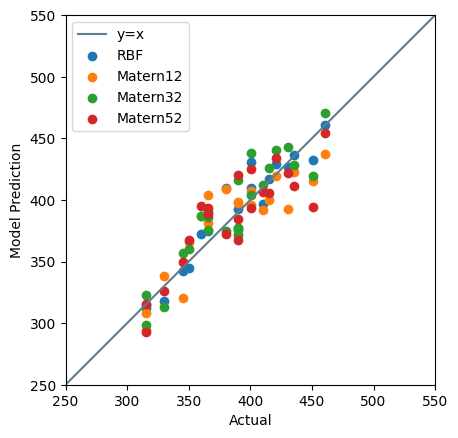

In [ ]:
plot_models(model, x_test, y_test,250,550)

Observation: Without scaling, we can see that none of the GP models give good predictions.

### 10.1.5.3 Scaled data

In [ ]:
n_params=5

#Split dataframe into parameters and outputs to do the normalization
param_values = df.values[:, :n_params]
breakout_time_values = df.values[:, n_params]

Define functions to scale data and apply

In [ ]:
def param_bounds():
    """Return parameter bounds"""

    #units: mm
    bounds_thickness = ( np.asarray(
        [[ 17.5, 22.5 ]]
        
    ))

    #units: kJ/mol
    bounds_laser_energy = (np.asarray(
        [[ 3650. , 4000. ]
        ]
    ))
    
    bounds_Be_gamma = (np.asarray(
        [[ 1.35 , 1.8 ]
        ]
    ))
    
    bounds_wall_opacity = (np.asarray(
        [[ 0.65 , 1.35 ]
        ]
    ))
    
    bounds_flux_limiter = (np.asarray(
        [[ 0.045 , 0.08 ]
        ]
    ))

    bounds = np.vstack((bounds_thickness,bounds_laser_energy,bounds_Be_gamma,bounds_wall_opacity,bounds_flux_limiter))

    return bounds

In [ ]:
def params_real_to_scaled(params, bounds):
    """Convert sample with physical units to values between 0 and 1"""
    return (params - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

In [ ]:
scaled_param_values = params_real_to_scaled(param_values, param_bounds())

In [ ]:
def breakout_time_bounds():
    """Return the bounds on breakout time in units of ps"""

    bounds = ( np.asarray(
        [ 305.013, 520.389 ],
    ))

    return bounds

In [ ]:
def values_real_to_scaled(values, bounds):
    """Convert breakout time with physical units to value between 0 and 1"""
    return (values - bounds[0]) / (bounds[1] - bounds[0])

In [ ]:
scaled_breakout_time_values = values_real_to_scaled(breakout_time_values, breakout_time_bounds())

After scaling, combine into a new dataframe.

In [ ]:
scaled_data = np.hstack((scaled_param_values,
                         scaled_breakout_time_values.reshape(-1,1)
                        ))

column_names = ["thickness",
                "laser_energy",
                "Be_gamma",
                "wall_opacity",
                "flux_limiter",
                "breakout_time"]

df_scaled = pd.DataFrame(scaled_data, columns=column_names)

In [ ]:
pd.options.display.max_rows=104
df_scaled

,thickness,laser_energy,Be_gamma,wall_opacity,flux_limiter,breakout_time
0,0.188,0.371429,0.382222,0.180000,0.391429,0.397844
1,0.164,-0.028571,0.333333,0.465714,0.142857,0.512313
2,0.418,0.514286,0.271111,0.112857,0.268571,0.629067
3,0.252,0.857143,0.371111,0.411429,0.322857,0.442793
4,0.812,0.000000,0.208889,0.371429,0.257143,0.884500
5,0.582,0.028571,0.124444,0.480000,0.314286,0.859641
6,0.786,0.514286,0.235556,0.140000,0.448571,0.791031
7,0.696,0.857143,0.468889,0.248571,0.200000,0.605091
8,0.226,0.200000,0.740000,0.125714,0.471429,0.185982
9,0.456,0.428571,0.653333,0.288571,0.460000,0.326805


Split into training and test sets and fit GP model

In [ ]:
n_params=5
x_train, y_train, x_test, y_test = shuffle_and_split(df_scaled, 5, fraction_train=0.8)

In [ ]:
# Fit model
model_RBF = run_gpflow_scipy(x_train, y_train, gpflow.kernels.RBF(lengthscales=np.ones(n_params)))
model_M12 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern12(lengthscales=np.ones(n_params)))
model_M32 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern32(lengthscales=np.ones(n_params)))
model_M52 = run_gpflow_scipy(x_train, y_train, gpflow.kernels.Matern52(lengthscales=np.ones(n_params)))

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[3.68466035e-01...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.71511105]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0018301530005278566
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[3.14649234e-01, 1.31179000e+00, 2.91352995e-02..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.000000000000876e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0.38387198...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.70822441]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0018001286516340419
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.90198477, 11.58101, 0.0573907..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0003086306921718e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0.35104789...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.73212732]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0018049615440418026
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.1841018, 0.77450893, 0.19087373..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.3271350119448466e-06


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(5, 1)",float64,[[0.37648888...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.70868079]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0019494311355095749
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[4.63021138e-01, 1.84111000e+00, 3.43532980e-02..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


In [ ]:
model = {'RBF':model_RBF,'Matern12':model_M12,'Matern32':model_M32,'Matern52':model_M52}

Model: RBF. Sum squared err: 0.000000
Model: Matern12. Sum squared err: 0.000000
Model: Matern32. Sum squared err: 0.000000
Model: Matern52. Sum squared err: 0.000000


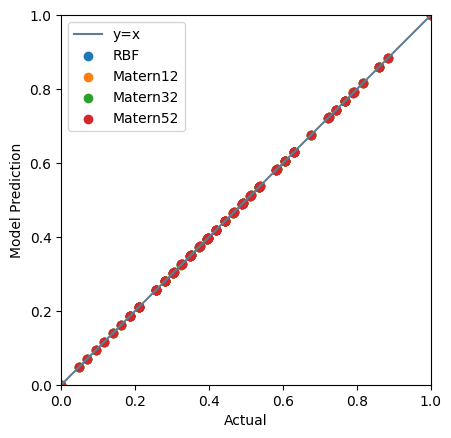

In [ ]:
plot_models(model, x_train, y_train,0,1)

Model: RBF. Sum squared err: 0.038864
Model: Matern12. Sum squared err: 0.039843
Model: Matern32. Sum squared err: 0.012888
Model: Matern52. Sum squared err: 0.040588


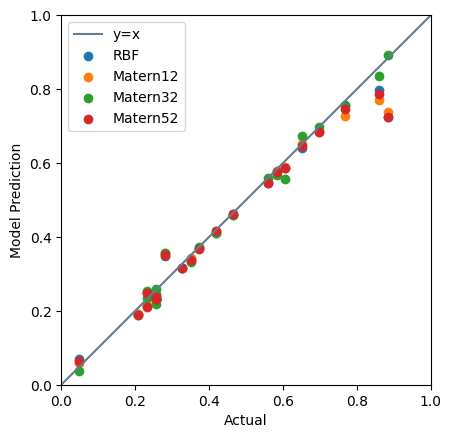

In [ ]:
plot_models(model, x_test, y_test,0,1)

Observation: GP predictions improve when scaling is used. In this case, Matern12 gives the lowest sum of squares error.

<!--NAVIGATION-->
< [10.0 Gaussian Process Emulators and Surrogate Models](https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.00-Gaussian-Process-Emulators-and-Surrogate-Models.html) | [Contents](toc.html) | [10.2 A simple example of Bayesian quadrature](https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.02-Bayesian-quadrature.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/10.01-Contributed-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.01-Contributed-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>